# Beginning Data Exploration

The following code takes the datasets referenced in the readme, and:

- Transforms them into dataframes
- Fixes issues with missing values
- Merges all observations into one dataframe on each date 

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
# load datasets 
cci = pd.read_csv('data/CCI.csv')
copper = pd.read_csv('data/CPRICING.csv')
gdp = pd.read_csv('data/GDP.csv')
alc = pd.read_csv('data/PCALC.csv')
rspread = pd.read_csv('data/T10YFF.csv')
man_emp = pd.read_csv('data/MANEMP.csv')
inflation = pd.read_csv('data/INFLATION.csv')
rec = pd.read_csv('data/USREC.csv')

In [3]:
r = pd.DataFrame(pd.date_range(start=rspread.DATE.min(), end=rspread.DATE.max()),columns=["DATE"])
rspread = r.merge(rspread.assign(DATE=pd.to_datetime(rspread['DATE'])), how='left').fillna(method='ffill')

In [4]:
# merge all datasets together
cci_copper = pd.merge(left=cci, right=copper, how='inner', on='DATE')
cc_gdp = pd.merge(left=cci_copper, right=gdp, how='inner', on='DATE')
cc_gdp_alc = pd.merge(left=cc_gdp, right=alc, how='left', on='DATE')
cc_gdp_alc = cc_gdp_alc.interpolate(method='linear')
cc_gdp_alc['DATE'] = pd.to_datetime(cc_gdp_alc['DATE'])
cc_gdp_alc_r = pd.merge(left=cc_gdp_alc, right=rspread, how='left', on='DATE')
cc_gdp_alc_r['DATE'] = pd.to_datetime(cc_gdp_alc_r['DATE'])
# get rid of bad data in the column before adding to set 
spread = cc_gdp_alc_r['T10YFF']
for i in range(len(spread)):
    # linearlly interpolate 
    if spread[i] == '.':
        spread[i] = (
            float(
            (float(spread[i - 1]) + float(spread[i + 1])) 
            / 2
            )
        )
spread_np = spread.astype(np.float64)
del cc_gdp_alc_r['T10YFF']
cc_gdp_alc_r['T10YFF'] = spread_np
# sloppy, but works
man_emp['DATE'] = pd.to_datetime(man_emp['DATE'])
cc_gdp_alc_r_emp = pd.merge(left=cc_gdp_alc_r, right=man_emp, how='left', on='DATE')
inflation['DATE'] = pd.to_datetime(inflation['DATE'])
indicators_w_rec = pd.merge(left=cc_gdp_alc_r_emp, right=inflation, how='left', on='DATE')
rec['DATE'] = pd.to_datetime(rec['DATE'])
indicators = pd.merge(left=indicators_w_rec, right=rec, how='left', on='DATE')
indicators['FPCPITOTLZGUSA'] = indicators['FPCPITOTLZGUSA'].interpolate(method='linear')
warnings.filterwarnings('ignore')

<ipython-input-4-7efb1271d015>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread[i] = (


In [5]:
# rename all columns 
indicators = indicators.rename(columns={
    'DATE' : 'date', 'CSCICP03USM665S' : 'cci', 'WPUSI019011' : 'copper',
    'USALORSGPNOSTSAM' : 'gdp', 'DAOPRC1A027NBEA' : 'alc',
    'T10YFF' : 'spread', 'MANEMP' : 'emp', 'FPCPITOTLZGUSA' : 'inflation',
     'USREC' : 'rec'
})
# remove nans in alc column --> have all dates defined already
indicators['alc'] = indicators['alc'].fillna(method='ffill')
# shift all recession values
indicators['rec_next_month'] = indicators['rec'].shift(-1)
indicators = indicators.drop('rec', axis=1)
# and drop the last row to remove nan value from shift 
indicators = indicators.drop(labels=646, axis=0)

## Final Merged Dataset with Raw Values:

In [6]:
indicators

,date,cci,copper,gdp,alc,spread,emp,inflation,rec_next_month
0,1967-01-01,100.913717,55.2,100.868342,8.853000,-0.36,18033,2.772786,0.0
1,1967-02-01,101.063223,55.2,100.720742,8.937333,0.52,17978,2.897703,0.0
2,1967-03-01,101.165526,54.0,100.553110,9.021667,0.91,17940,3.022621,0.0
3,1967-04-01,101.242167,53.1,100.379758,9.106000,0.00,17878,3.147538,0.0
4,1967-05-01,101.297345,52.4,100.219859,9.190333,0.77,17832,3.272456,0.0
...,...,...,...,...,...,...,...,...,...
641,2020-06-01,98.281638,359.8,92.322976,167.134000,0.61,11999,1.812210,1.0
642,2020-07-01,98.301124,383.5,93.984370,167.134000,0.61,12037,1.812210,1.0
643,2020-08-01,98.526634,394.3,95.633067,167.134000,0.45,12068,1.812210,1.0
644,2020-09-01,98.875920,401.6,95.741927,167.134000,0.59,12123,1.812210,1.0


## Making sure no months were lost 

In [7]:
# make sure we have data for each month within the period
months = (2020-1966) * 12 - 1 - 1
print(months == indicators['date'].count())

True


## Next Steps

- Normalize alcohol consumption data. Use a rate of change month to month instead of raw values 
- Continue analysis on data, visualize 

In [8]:
indicators.describe()

,cci,copper,gdp,alc,spread,emp,inflation,rec_next_month
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.00000,646.000000,646.000000
mean,99.834676,196.616254,99.981901,65.794770,0.972330,16042.46904,3.965467,0.142415
std,1.604923,135.953958,1.342601,42.435485,1.741023,2434.46625,2.708368,0.349746
min,95.638395,52.100000,90.653469,8.853000,-7.100000,11414.00000,-0.355546,0.000000
25%,98.609359,98.725000,99.453070,31.041375,0.070000,13933.00000,2.207148,0.000000
50%,100.284141,134.400000,100.026559,52.966000,1.210000,17208.50000,3.096949,0.000000
75%,100.973693,316.900000,100.770882,102.421875,2.290000,17852.50000,4.857069,0.000000
max,103.123708,535.400000,102.888625,167.134000,3.810000,19553.00000,13.549202,1.000000


### Data Usage

It appears that using the raw values of the consumer confidence index, normalized gdp, and the 10-FF yield spread will be appropriate, since the values aren't uniformly changing over time. However, alcohol sales and the price of copper appears to increase as time moves on. To account for this, we will add a column that finds the percent change of each column per time interval. We will also use the percent change for manufacturing employment and inflation, since recessionary periods see sharp declines in these metrics.

When finding percent change in inflation rates, we realized that we ran into problems computing the percent change in values which were of different signs. There is no standardized method to circumvent this which I could find, but a common work around is to divide by the absolute value of the previous value. I did this below instead of using the pct_change() method for the inflation column for more accurate results.

In [9]:
indicators['copper_pct'] = indicators['copper'].pct_change()
indicators['alc_pct'] = indicators['alc'].pct_change()
indicators['emp_pct'] = indicators['emp'].pct_change()
inf_list = list(indicators['inflation'])
pct_change = [0]
# drop 
for i in range(1, len(inf_list)):
    b = inf_list[i]
    a = inf_list[i - 1]
    chng = (b - a) / np.absolute(a)
    pct_change.append(chng)

In [10]:
indicators['copper_pct'] = indicators['copper_pct'].fillna(0)
indicators['alc_pct'] = indicators['alc_pct'].fillna(0)
indicators['emp_pct'] = indicators['emp_pct'].fillna(0)
indicators['inflation_pct'] = pct_change

indicators = indicators[[
    'date', 'cci', 'copper', 'copper_pct', 'gdp', 'alc', 'alc_pct',
    'spread', 'emp', 'emp_pct', 'inflation', 'inflation_pct',
    'rec_next_month'
]]
indicators = indicators.drop('inflation_pct', axis=1)
indicators.to_csv('data/full_time_indicators.csv')
indicators.describe()

,cci,copper,copper_pct,gdp,alc,alc_pct,spread,emp,emp_pct,inflation,rec_next_month
count,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.00000,646.000000,646.000000,646.000000
mean,99.834676,196.616254,0.003768,99.981901,65.794770,0.004563,0.972330,16042.46904,-0.000592,3.965467,0.142415
std,1.604923,135.953958,0.038009,1.342601,42.435485,0.002872,1.741023,2434.46625,0.006045,2.708368,0.349746
min,95.638395,52.100000,-0.204033,90.653469,8.853000,-0.002637,-7.100000,11414.00000,-0.102532,-0.355546,0.000000
25%,98.609359,98.725000,-0.016703,99.453070,31.041375,0.002808,0.070000,13933.00000,-0.001848,2.207148,0.000000
50%,100.284141,134.400000,0.001966,100.026559,52.966000,0.004114,1.210000,17208.50000,0.000029,3.096949,0.000000
75%,100.973693,316.900000,0.023680,100.770882,102.421875,0.006441,2.290000,17852.50000,0.001818,4.857069,0.000000
max,103.123708,535.400000,0.264544,102.888625,167.134000,0.011304,3.810000,19553.00000,0.029339,13.549202,1.000000


array([[<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>]], dtype=object)

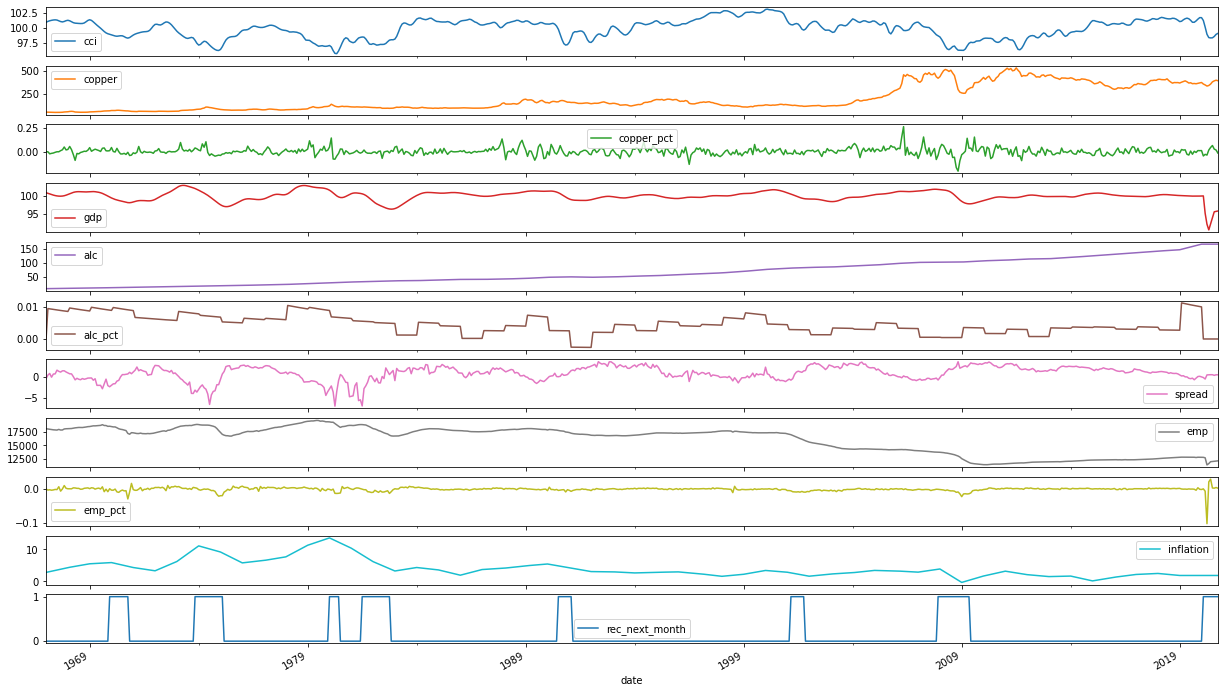

In [11]:
indicators.plot(x='date', subplots=True, layout=(11,1), figsize=(21,13))

array([[<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
       [<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
        <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>]],
      dtype=object)

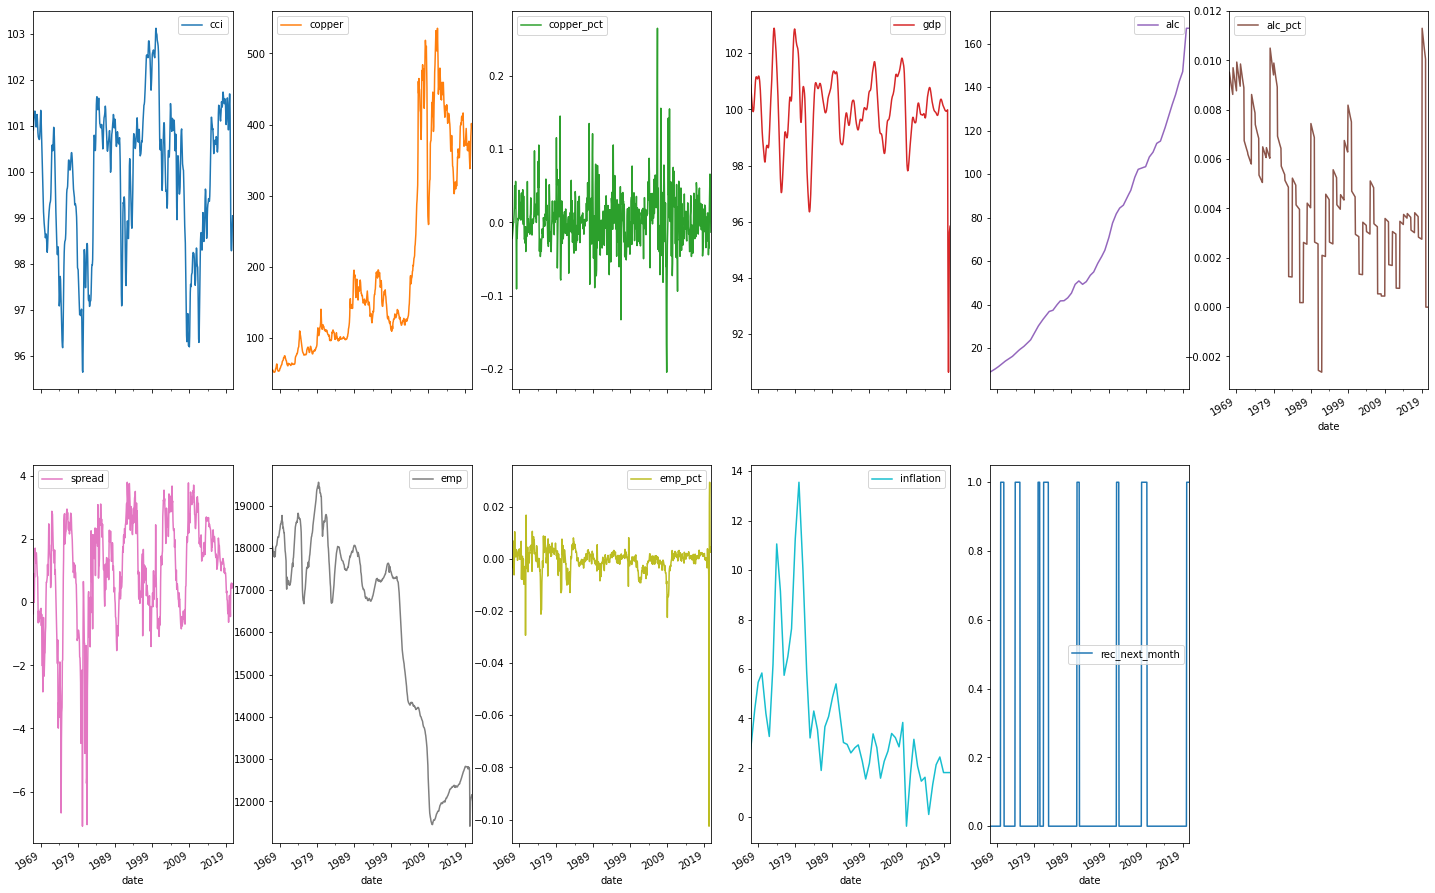

In [12]:
# fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(25, 17))
indicators.plot(x='date', subplots=True, layout=(2,6), figsize=(25,17))

cci              -0.519309
copper           -0.018204
copper_pct       -0.097005
gdp              -0.290193
alc              -0.046428
alc_pct          -0.023987
spread           -0.318903
emp               0.059942
emp_pct          -0.404033
inflation         0.201687
rec_next_month    1.000000
Name: rec_next_month, dtype: float64

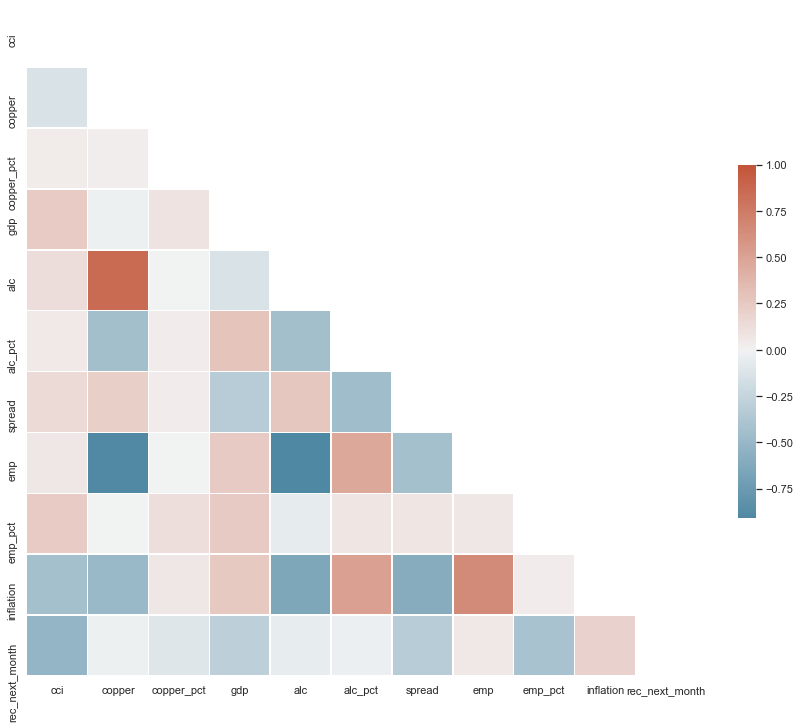

In [13]:
sns.set_theme(style="white")
corr = indicators.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr['rec_next_month']